In [1]:
setwd("../..")
list.files()

[1] "HapMap3_r2_b36_2009.zip"                       
 [2] "README.md"                                     
 [3] "Rplots.pdf"                                    
 [4] "Scripts"                                       
 [5] "SwitchPoints_SetA02_withOutHaplotypeBreaks.png"
 [6] "data"                                          
 [7] "makeHapFile.py"                                
 [8] "merge_haplotypePandas.py"                      
 [9] "phase-Extender.py"                             
[10] "phase-Extender2.py"                            
[11] "plot_haplotype_stats.py"                       
[12] "requirements.txt"                              
[13] "temp5"                                         
[14] "temp6"                                         
[15] "tests"                                         
[16] "vcf_to_table-v2.py"

In [2]:

##########  Switch errors test - Set B (first round of phaseExtension) ########## 
#####  Read the required data  ###### 

## Import "truth haplotype" for SetB
truthHaplotype_NA12891 <- read.table('data/SetB/truth_Haplotype_NA12891.txt', header = TRUE)
head(truthHaplotype_NA12891)
  #**Note: R doesn't allow to use ":" in header name and it is automatically renamed to "."
  # you can see this in the output 


,CHROM,POS,NA12891.PI,NA12891.PG_al
,<int>,<int>,<dbl>,<chr>
1,20,9795,1,T|G
2,20,11799,1,T|C
3,20,17094,1,A|G
4,20,24962,1,C|T
5,20,28655,1,G|A
6,20,35416,2,C|A


In [3]:

# change the name of the header
colnames(truthHaplotype_NA12891)[colnames(truthHaplotype_NA12891)=="NA12891.PI"] <- "true.NA12891.PI"
colnames(truthHaplotype_NA12891)[colnames(truthHaplotype_NA12891)=="NA12891.PG_al"] <- "true.NA12891.PG_al"



In [4]:

## Import "phased haplotype" for SetB
phased_SetB_NA12891 <- read.table('data/SetB_02/phased_Haplotype_NA12891.txt', header = TRUE)
# or, we can use the file "extended_haplotype_NA12891.txt" from the folder "/SetB/phased_NA12891_SetB_run01/"
head(phased_SetB_NA12891)


,CHROM,POS,NA12891.PI,NA12891.PG_al
,<int>,<int>,<dbl>,<chr>
1,20,9795,1,T|G
2,20,11799,1,T|C
3,20,17094,1,A|G
4,20,24962,1,C|T
5,20,28655,1,G|A
6,20,35416,1,C|A


In [5]:

# change the name of the header
colnames(phased_SetB_NA12891)[colnames(phased_SetB_NA12891)=="NA12891.PI"] <- "phased.NA12891.PI"
colnames(phased_SetB_NA12891)[colnames(phased_SetB_NA12891)=="NA12891.PG_al"] <- "phased.NA12891.PG_al"


## Merge the truth and phased data set to identify switch errors
merged.data <- merge(truthHaplotype_NA12891, phased_SetB_NA12891,
                     by=c("CHROM", "POS"))
head(merged.data)


,CHROM,POS,true.NA12891.PI,true.NA12891.PG_al,phased.NA12891.PI,phased.NA12891.PG_al
,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,20,10003480,391,T|G,383,G|T
2,20,10007072,391,A|C,383,C|A
3,20,10008681,391,C|T,383,T|C
4,20,10012529,392,G|A,383,A|G
5,20,10015264,392,A|G,383,G|A
6,20,10016488,392,T|C,383,C|T


In [6]:

# set the data in order by "POS" - ** it's very important to do this **
merged.data <- merged.data[order(merged.data$POS),]

# after merging, the row-index becomes random; so let's put it in order
rownames(merged.data) <- NULL

# Now, compare the "truth haplotype" with "phased haplotype" and ...
# ... find the sites where haplotype phasing switched
merged.data$match <- ifelse((merged.data$true.NA12891.PG_al == merged.data$phased.NA12891.PG_al), 0, 1)
# **Note: the "match" column should have values "0's" and "1's". A continous "0" or "1" indicates 
# .. properly phased block. But, transition from 0 -> 1 or from 1 -> 0 suggests a "Switch Error" betweeen the blocks.


quartz_off_screen 
                3

pdf 
  2

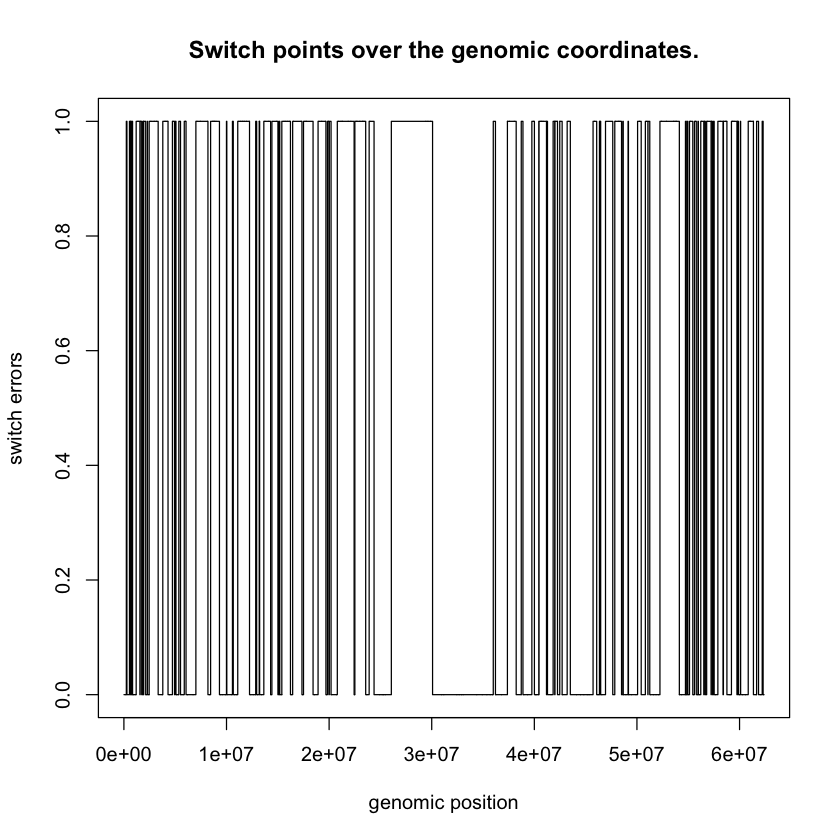

In [7]:

# Now, plot the "Switch Error" points as png
filename <- "data/rplots/SwitchPoints_SetB_withOutHaplotypeBreaks.png"
plot(merged.data$POS, merged.data$match, main = "Switch points over the genomic coordinates.", type = "s", 
     xlab = "genomic position", ylab = "switch errors")
dev.copy(device = png, filename = filename, width = 1600, height = 600)

#title(main = "Switch points", xlab = 'genomic coordinates', ylab = 'switch points')
dev.off()



In [8]:

# Compute switch error rates 
number_of_hets <- length(merged.data$match)
num_of_switch <- 0
prev_match <- merged.data$match[1]
for (item in merged.data$match){
  curr_match = item
  if (curr_match != prev_match){
    num_of_switch = num_of_switch + 1
    
    # reset the "previous match" value
    prev_match = curr_match}}

switch_err_rate = num_of_switch/(number_of_hets)
switch_err_rate
# [1] 0.01272502


[1] 0.01572522

In [9]:

# switch error rate per mb
# the size of human Chr 22 is about 62.3 mb
switch_error_rate_perMb = switch_err_rate/(62)
switch_error_rate_perMb
# [1] 0.0002819994



[1] 0.0002536326

In [10]:


# switch error after accounting for the initial number of RBphased blocks
######## Fix the switch points by taking "haplotype breaks" into account. ##########
## The above switch point data (i.e "match") and the plot we obtained above doesn't account for break in haplotypes.
# Since our haplotype aren't completely merged genome/chromosome wide. The switch points needs to be defined per block. 

## So, now we compute switch point by including changes in "PI" values.
# Now, the "switch points" are addressed when :
  # we see 0 -> 1, or when 1 -> 0 in the "match" data
  # PI of the haplotype block changes
    # ** So, now we need to account for the match and also for change in haplotype block index.

# the length (number of rows) of the dataframe
seq_len <- length(merged.data$match)
seq_len

# set empty variables 
previous_match <- 0
hap_size <- 0
haplotype_sizes <- integer()  # to store the size of haplotype extended truly.
previous_pi <- 1 
haplotype_breaks <- integer()

# run a for loop to find switch points 
for (ith in c(1:seq_len)){
  current_match = merged.data$match[ith]
  current_pi = merged.data$phased.NA12891.PI[ith]
  if (previous_match == current_match & previous_pi == current_pi) {
    hap_size = hap_size + 1}
  else if (previous_match != current_match | previous_pi != current_pi) {
    # store the haplotype size of properly phased (extended) block
    haplotype_sizes <- c(haplotype_sizes, hap_size)
    hap_size <- 1}  # reset the haplotype size to 1
  
  # store the last haplotype size when the for loop reaches the end
  if (ith == seq_len){
    haplotype_sizes <- c(haplotype_sizes, hap_size)}
  
  # also find the genomic positions where haplotype breaks occur 
  if (previous_pi != current_pi){
    haplotype_breaks <- c(haplotype_breaks, merged.data$POS[ith])}
  
  # update the previous match and pi values for next for-loop 
  previous_match = current_match
  previous_pi = current_pi }


## Identify switch points and compute "switch error" rates. 
# the total number of haplotype blocks represent frequecy of switch points
freq_of_switch = length(haplotype_sizes)
total_possible_switch = sum(haplotype_sizes) # or number of hets site
head(haplotype_sizes)


[1] 9666

[1] 17 15 19  4 19  6

In [11]:

# calculate switch error rate
switch_error_rate = (freq_of_switch/total_possible_switch)
switch_error_rate
# [1] 0.0190358


[1] 0.02607076

In [12]:

# switch error rate per mb
switch_error_rate_perMb = switch_error_rate/(62)
switch_error_rate_perMb
# [1] 0.0002819994


[1] 0.0004204962

In [13]:

## Now, add another column that represent the fully accounted haplotype switchpoints.
phase_state = 0
match_by_pi <- integer()
for (sizes in haplotype_sizes) {
  match_by_pi <- c(match_by_pi, rep(phase_state, sizes))
  
  # change the phase state for next loop
  if (phase_state == 0){
    phase_state = 1}
  else if (phase_state == 1){
    phase_state = 0} }

## add data "match02" to the dataframe
merged.data$match_by_pi <- match_by_pi


quartz_off_screen 
                3

pdf 
  2

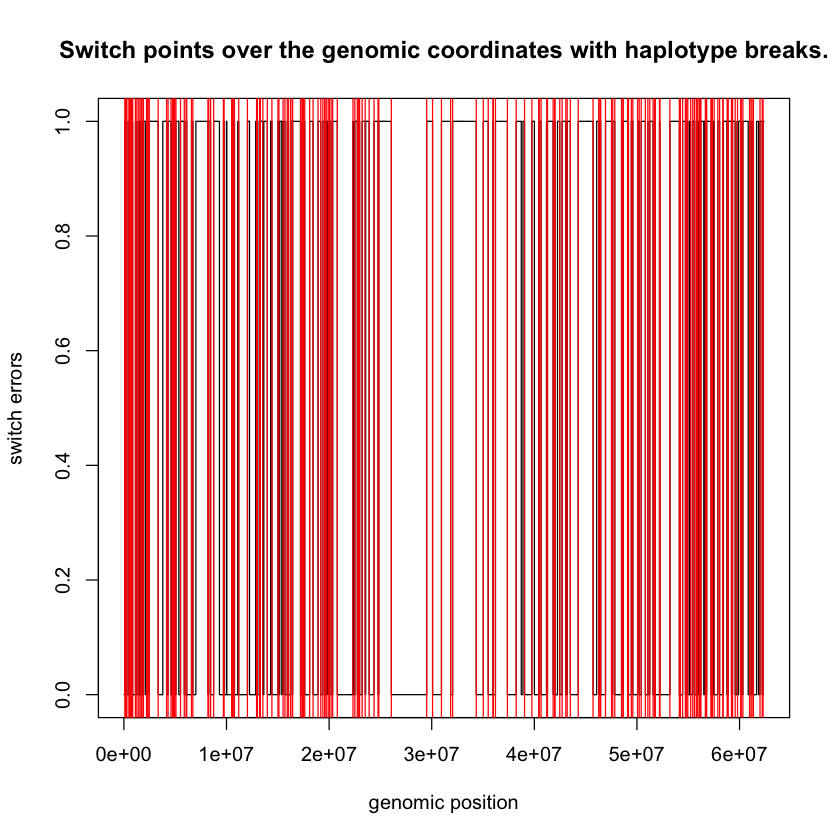

In [14]:

## Now, make switch points plot by accounting for the haplotype breaks. 
# for that we will create another column with updated matches between truth and phased haplotypes
filename <- "data/rplots/SwitchPoints_SetB_includingHaplotypeBreaks.png"
plot(merged.data$POS, merged.data$match_by_pi, main = "Switch points over the genomic coordinates with haplotype breaks.", type = "s", 
     xlab = "genomic position", ylab = "switch errors")

## We can now overlay the haplotype breaks position on the top of switch points plot
abline(v=haplotype_breaks, col='red')
dev.copy(device = png, filename = filename, width = 1600, height = 600)

dev.off()


In [15]:


# for convenience let's convert this haplotype size list into integer array
haplotype_size_numeric <- as.numeric(unlist(haplotype_sizes))
head(haplotype_size_numeric)


[1] 17 15 19  4 19  6

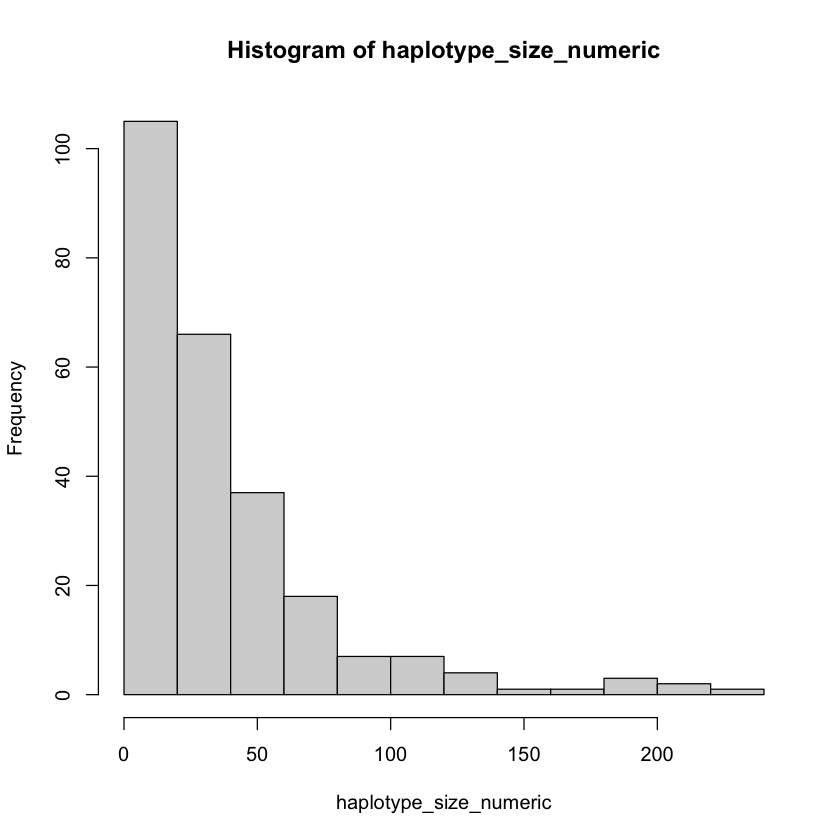

quartz_off_screen 
                3

pdf 
  2

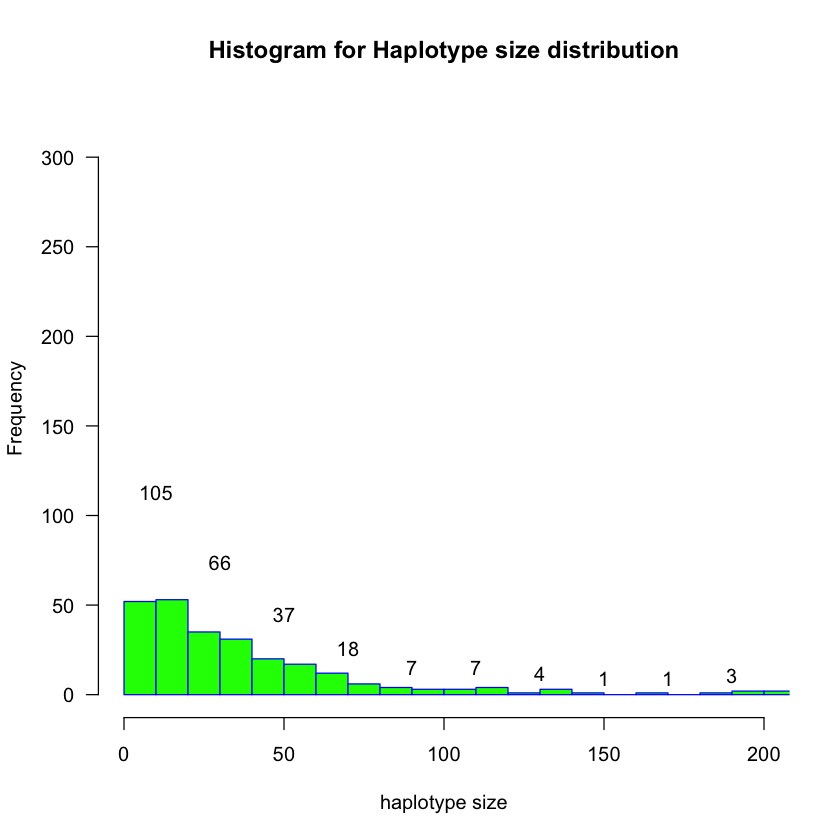

In [16]:

## Let's plot a histogram of the haplotype size distribution 
hisHap <- hist(haplotype_size_numeric)  # general histogram metrics for the data 
filename <- "data/rplots/Histogram_ofHaplotypeSizeDistribution_SetB.png"
hist(haplotype_size_numeric, 
     main="Histogram for Haplotype size distribution", 
     xlab="haplotype size", 
     border="blue", 
     col="green",
     xlim=c(0,200),
     ylim = c(0,320),
     las=1, 
     breaks=20)
# add the size of the frequency to the histogram plot 
text(hisHap$mids,hisHap$counts,labels=hisHap$counts, adj=c(0.5, -0.5))
dev.copy(device = png, filename = filename, width = 1600, height = 600)

dev.off()


quartz_off_screen 
                3

pdf 
  2

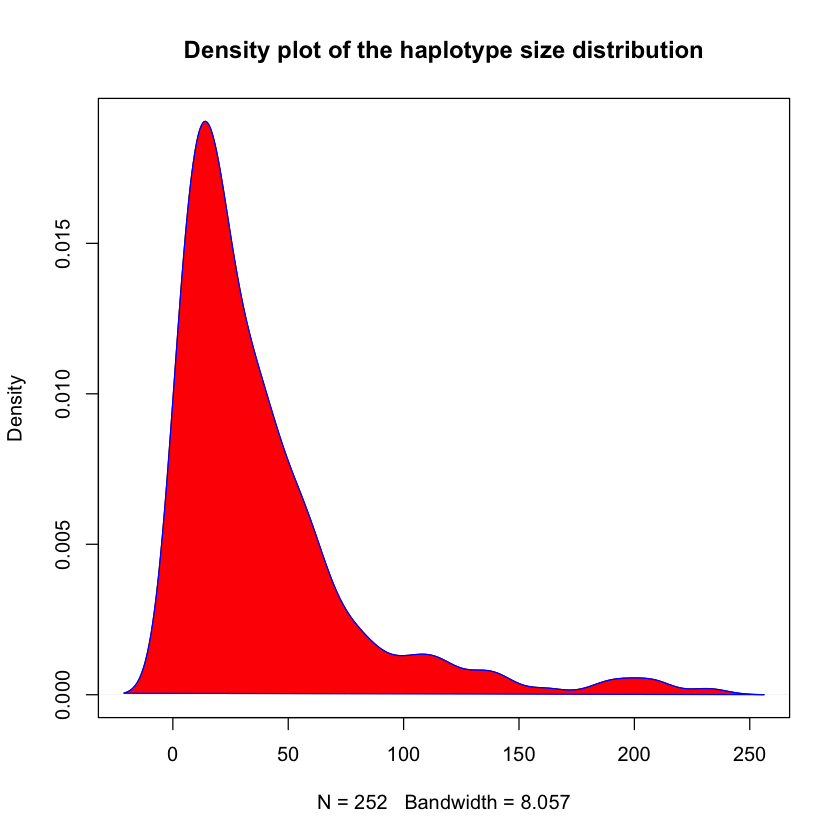

In [17]:

## Density plot
densHap <- density(haplotype_size_numeric)
filename <- "data/rplots/DensityPlot_ofHaplotypeSizeDistribution_SetB.png"
plot(densHap, main = "Density plot of the haplotype size distribution")
polygon(densHap, col = 'red', border = 'blue')
dev.copy(device = png, filename = filename, width = 1600, height = 600)

dev.off()


#### Completed analyses on Set-B  #######